In [1]:
# version 4
# ---------------------------------
# - Conditional SAGAN baseline, sticking to the paper 
# - original paper uses hinge loss
# - num epochs = 500

In [2]:
COMPUTE_LB = False

In [3]:
import time
kernel_start_time = time.perf_counter()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import SVG, display

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os, time, glob, shutil
starttime = time.time()

import warnings
warnings.simplefilter("ignore")

from pathlib import Path
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from argparse import Namespace
import numpy as np
import random
import torch
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.utils as vutils

from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint, Timer
from ignite.metrics import RunningAverage

In [4]:
args = Namespace(
    seed=123,
    disable_cuda=False,
    device=None,
    debug=False,
    num_workers=4,
    # use this for exp name
    CKPT_PREFIX = 'sagan_hinge_loss',
    exp_name = None,

    ########## Ignite Stuff ###################
    PRINT_FREQ = 600,
    FAKE_IMG_FNAME = 'fake_sample_epoch_{:04d}.png',
    REAL_IMG_FNAME = 'real_sample_epoch_{:04d}.png',
    LOGS_FNAME = 'logs.tsv',
    PLOT_FNAME = 'plot.svg',
    SAMPLES_FNAME = 'samples.svg',
    output_dir = '../output_dir/',
    alpha = 0.98, # smoothing constant for exponential moving average
    
    ######### Dataset Related #################
    shuffle=True,
    datapath=Path('../input/all-dogs/'),
    root_images=Path("../input/all-dogs"),
    root_annots=Path("../input/Annotation/"),
    
    ######### Training Params ######################
    num_epochs=500,
    lrD=4e-4,
    lrG=1e-4,
    beta1 = 0., #SAGAN params (wuuuud?)
    beta2 = 0.9,
    batch_size=64,
    weight_decay=0.001,
    log_interval=100,
    num_disc_update=1,

    ######### Model Params #########################
    num_classes=120,
    image_size=64,
    in_channels=3,
    num_feature_maps_gen=64,
    num_feature_maps_disc=64,
    latent_dim=128,
    input_dim=64*64,
    hidden_size=400,    
    dropout_p=0.2,
)
args.exp_name = args.CKPT_PREFIX + f"_{args.num_epochs}ep_{args.batch_size}bs_{args.num_disc_update}ndisc"
print("="*100)
print(args.exp_name)
print("="*100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=args.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

sagan_hinge_loss_500ep_64bs_1ndisc


In [5]:
### All utility functions
def get_bbox(img_path):
    "image path as input and return list of bounding boxes around dogs (could be more than one per image)"
    annotation_basename = os.path.splitext(os.path.basename(img_path))[0]
    annotation_dirname = next(dirname for dirname in os.listdir(args.root_annots) if dirname.startswith(annotation_basename.split('_')[0]))
    annotation_filename = os.path.join(args.root_annots, annotation_dirname, annotation_basename)
    tree = ET.parse(annotation_filename)
    root = tree.getroot()
    objects = root.findall('object')
    bboxes = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        w = np.min((xmax - xmin, ymax - ymin))
        bboxes.append((xmin, ymin, xmin+w, ymin+w))
    return bboxes

def doggo_loader(img_path):
    img = torchvision.datasets.folder.default_loader(img_path) # default loader
    bbox = get_bbox(img_path)[-1]
    return img.crop(bbox)

def clear_output_dir():
    try:
        shutil.rmtree(args.output_dir)
    except FileNotFoundError:
        pass

def check_gen_samples(dataloader, img_list):
    "Plot tile of real and generated images"
    
    real_batch = next(iter(dataloader))
    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()
    
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1, transform2=None):
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        self.labels = []
        for img_name in tqdm(self.img_names):
            img_path = os.path.join(img_dir, img_name)
            img = Image.open(img_path)
            annotation_basename = os.path.splitext(os.path.basename(img_path))[0]
            annotation_dirname = next(dirname for dirname in os.listdir(args.root_annots) if dirname.startswith(annotation_basename.split('_')[0]))
            annotation_filename = os.path.join(args.root_annots, annotation_dirname, annotation_basename)
            tree = ET.parse(annotation_filename)
            root = tree.getroot()
            objects = root.findall('object')
            bboxes = []
            for o in objects:
                bndbox = o.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                bbox = (xmin, ymin, xmin+w, ymin+w)
                img_crop = img.crop(bbox)
                
                self.imgs.append(self.transform1(img_crop))
                self.labels.append(annotation_dirname.split('-')[1].lower())
                
    def __getitem__(self, index):
        img = self.imgs[index]
        label = self.labels[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img, label

    def __len__(self):
        return len(self.imgs)

def get_transforms():
    
    # this normalizes pixel values between [-1,1]
    # https://www.kaggle.com/jesucristo/gan-introduction565419
    # GANHACK #1
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    random_transforms = [transforms.ColorJitter(), 
                         transforms.RandomRotation(degrees=1)]
    random_cropper = [torchvision.transforms.CenterCrop(args.image_size), torchvision.transforms.RandomCrop(args.image_size)]


    # First preprocessing of data
    transform1 = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
    ])

    transform2 = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply(random_transforms, p=0.3),
        transforms.ToTensor(),
        normalize]) 
    
    return transform1, transform2

transform1, transform2 = get_transforms()
train_data = DogDataset(img_dir=args.root_images,
                        transform1=transform1,
                        transform2=transform2)

decoded_dog_labels = {i:breed for i, breed in enumerate(sorted(set(train_data.labels)))}
encoded_dog_labels = {breed:i for i, breed in enumerate(sorted(set(train_data.labels)))}
train_data.labels = [encoded_dog_labels[l] for l in train_data.labels] # encode dog labels in the data generator
dataloader = torch.utils.data.DataLoader(train_data, 
                                         shuffle=True,
                                         batch_size=args.batch_size, 
                                         num_workers=args.num_workers)

100%|██████████| 20579/20579 [00:58<00:00, 353.41it/s]


In [7]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)


def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return nn.utils.spectral_norm(nn.Conv2d(in_channels=in_channels, 
                                            out_channels=out_channels, 
                                            kernel_size=kernel_size,
                                            stride=stride, 
                                            padding=padding, 
                                            dilation=dilation, 
                                            groups=groups, 
                                            bias=bias))


def snlinear(in_features, out_features):
    return nn.utils.spectral_norm(nn.Linear(in_features=in_features, out_features=out_features))


def sn_embedding(num_embeddings, embedding_dim):
    return nn.utils.spectral_norm(nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim))

# ----------------------------------------------------------------------------
# Pixelwise feature vector normalization.
# reference: https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
# ----------------------------------------------------------------------------
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y
    
class MinibatchStdDev(nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape
        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)
        # [1 x C x H x W]  Calc standard deviation over batch
        y = torch.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size,1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = torch.cat([x, y], 1)
        # return the computed values:
        return y    
    
    
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0.).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x 

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].fill_(1.)  # Initialize scale to 1
        self.embed.weight.data[:, num_features:].zero_()    # Initialize bias at 0

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out    

class Self_Attn(nn.Module):
    """ Self attention Layer"""

    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_attn = snconv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """
            inputs :
                x : input feature maps(B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        # Out
        out = x + self.sigma*attn_g
        return out    
    

In [8]:
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(GenBlock, self).__init__()
        self.cond_bn1 = ConditionalBatchNorm2d(in_channels, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.ps1 = nn.PixelShuffle(2),
        self.snconv2d1 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.cond_bn2 = ConditionalBatchNorm2d(out_channels, num_classes)
        self.snconv2d2 = snconv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.snconv2d0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, labels):
        x0 = x

        x = self.cond_bn1(x, labels)
        x = self.relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest') # upsample
        x = self.snconv2d1(x)
        x = self.cond_bn2(x, labels)
        x = self.relu(x)
        x = self.snconv2d2(x)

        x0 = F.interpolate(x0, scale_factor=2, mode='nearest') # upsample
        x0 = self.snconv2d0(x0)

        out = x + x0
        return out
    
class DiscOptBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscOptBlock, self).__init__()
        self.snconv2d1 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.snconv2d2 = snconv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.downsample = nn.AvgPool2d(2)
        self.snconv2d0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x0 = x

        x = self.snconv2d1(x)
        x = self.relu(x)
        x = self.snconv2d2(x)
        x = self.downsample(x)

        x0 = self.downsample(x0)
        x0 = self.snconv2d0(x0)

        out = x + x0
        return out


class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscBlock, self).__init__()
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.snconv2d1 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.snconv2d2 = snconv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.downsample = nn.AvgPool2d(2)
        self.ch_mismatch = False
        if in_channels != out_channels:
            self.ch_mismatch = True
        self.snconv2d0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, downsample=True):
        x0 = x

        x = self.relu(x)
        x = self.snconv2d1(x)
        x = self.relu(x)
#         x = self.snconv2d2(x)
        if downsample:
            x = self.downsample(x)

        if downsample or self.ch_mismatch:
            x0 = self.snconv2d0(x0)
            if downsample:
                x0 = self.downsample(x0)

        out = x + x0
        return out
    
class Generator(nn.Module):
    """Generator."""

    def __init__(self):
        super(Generator, self).__init__()

        self.z_dim = args.latent_dim
        self.g_conv_dim = args.num_feature_maps_gen
        
        self.snlinear0 = snlinear(in_features=self.z_dim, out_features=self.g_conv_dim*8*4*4)
        self.block1 = GenBlock(self.g_conv_dim*8, self.g_conv_dim*8, args.num_classes)
        self.block2 = GenBlock(self.g_conv_dim*8, self.g_conv_dim*4, args.num_classes)
        self.block3 = GenBlock(self.g_conv_dim*4, self.g_conv_dim*2, args.num_classes)
        self.self_attn = Self_Attn(self.g_conv_dim*2)
        self.block4 = GenBlock(self.g_conv_dim*2, self.g_conv_dim, args.num_classes)
#         self.block5 = GenBlock(self.g_conv_dim, self.g_conv_dim, args.num_classes)
        self.bn = nn.BatchNorm2d(self.g_conv_dim, eps=1e-5, momentum=0.0001, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.snconv2d1 = snconv2d(in_channels=self.g_conv_dim, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

        # Weight init
        self.apply(init_weights)

    def forward(self, z, labels):
#         import pdb; pdb.set_trace()
        # n x z_dim
        act0 = self.snlinear0(z)            # n x g_conv_dim*8*2*2
        act0 = act0.view(-1, self.g_conv_dim*8, 4, 4) # n x g_conv_dim*16 x 2 x 2
        act1 = self.block1(act0, labels)    # n x g_conv_dim*8 x 4 x 4
        act2 = self.block2(act1, labels)    # n x g_conv_dim*4 x 8 x 8
        act3 = self.block3(act2, labels)    # n x g_conv_dim*2 x 16 x 16
        act3 = self.self_attn(act3)         # n x g_conv_dim*2 x 16 x 16
        act4 = self.block4(act3, labels)    # n x g_conv_dim*1 x 32 x 32
#         act5 = self.block5(act4, labels)    # n x g_conv_dim  x 64 x 64
#         act5 = self.bn(act4)                # n x g_conv_dim  x 64 x 64
#         act5 = self.relu(act5)              # n x g_conv_dim  x 64 x 64
        act6 = self.snconv2d1(act4)         # n x 3 x 64 x 64
        act6 = self.tanh(act6)              # n x 3 x 64 x 64
        return act6

    
class Discriminator(nn.Module):
    """Discriminator."""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.d_conv_dim = args.num_feature_maps_disc
        self.opt_block1 = DiscOptBlock(3, self.d_conv_dim)
        self.block1 = DiscBlock(self.d_conv_dim, self.d_conv_dim*2)
        self.self_attn = Self_Attn(self.d_conv_dim*2)
        self.block2 = DiscBlock(self.d_conv_dim*2, self.d_conv_dim*4)
        self.block3 = DiscBlock(self.d_conv_dim*4, self.d_conv_dim*4)
        self.block4 = DiscBlock(self.d_conv_dim*4, self.d_conv_dim*8)
        self.block5 = DiscBlock(self.d_conv_dim*8, self.d_conv_dim*8)
        self.relu = nn.ReLU(inplace=True)
        self.snlinear1 = snlinear(in_features=self.d_conv_dim*8, out_features=1)
        self.sn_embedding1 = sn_embedding(args.num_classes, self.d_conv_dim*8)

        # Weight init
        self.apply(init_weights)
        nn.init.xavier_uniform_(self.sn_embedding1.weight)

    def forward(self, x, labels):
        # n x 3 x 64 x 64
        h0 = self.opt_block1(x) # n x d_conv_dim   x 32 x 32
        h1 = self.block1(h0)    # n x d_conv_dim*2 x 16 x 16
        h1 = self.self_attn(h1) # n x d_conv_dim*2 x 16 x 16
        h2 = self.block2(h1)    # n x d_conv_dim*4 x 8 x 8
        h3 = self.block3(h2)    # n x d_conv_dim*4 x  4 x  4
        h4 = self.block4(h3)    # n x d_conv_dim*8 x 2 x  2
        h5 = self.block5(h4, downsample=False)  # n x d_conv_dim*8 x 2 x 2
        h5 = self.relu(h5)              # n x d_conv_dim*8 x 2 x 2
        h6 = torch.sum(h5, dim=[2,3])   # n x d_conv_dim*8
        output1 = torch.squeeze(self.snlinear1(h6)) # n x 1
        # Projection
        h_labels = self.sn_embedding1(labels)   # n x d_conv_dim*8
        proj = torch.mul(h6, h_labels)          # n x d_conv_dim*8
        output2 = torch.sum(proj, dim=[1])      # n x 1
        # Out
        output = output1 + output2              # n x 1
        return output    

In [9]:
netG = Generator().to(device)
netD = Discriminator().to(device)

weights_init(netG)
weights_init(netD)
print("Generator parameters:    ", sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator parameters:", sum(p.numel() for p in netD.parameters() if p.requires_grad))

fixed_noise = torch.randn(64, args.latent_dim, device=device)
dog_labels = torch.randint(0, len(encoded_dog_labels), (64, ), device=device)

# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0.0

BCE_stable = nn.BCEWithLogitsLoss()
optimizerD = optim.Adam(netD.parameters(), lr=args.lrD, betas=(args.beta1, args.beta2))
optimizerG = optim.Adam(netG.parameters(), lr=args.lrG, betas=(args.beta1, args.beta2))

def step(engine, batch):
    def train_D(images, labels):
        """
        Run 1 step of training for discriminator
        Input:
            images: batch of images (reshaped to [batch_size, -1])
        Output:
            D_loss: non-saturing loss for discriminator,
            -E[log( sigmoid(D(x) - E[D(G(z))]) )]
              - E[log(1 - sigmoid(D(G(z)) - E[D(x)]))]
        """
        noise = torch.randn(args.batch_size, args.latent_dim, device=device)
        G_output = netG(noise, labels)
        
        # classify the generated and real batch images
        Dx_score = netD(images, labels) # D(x)
        DG_score = netD(G_output, labels) # D(G(z))
        
        # Compute RA Hinge loss
        D_loss = (torch.mean(torch.nn.ReLU()(1.0 - (Dx_score - torch.mean(DG_score)))) + 
                  torch.mean(torch.nn.ReLU()(1.0 + (DG_score - torch.mean(Dx_score)))))/2
        
#         D_loss = (BCE_stable(Dx_score - torch.mean(DG_score), real_labels) +\
#                   BCE_stable(DG_score - torch.mean(Dx_score), fake_labels))/2
        
        return D_loss, F.sigmoid(Dx_score).mean().item(), F.sigmoid(DG_score).mean().item()
    
    def train_G(images, labels):
        """ Run 1 step of training for generator
            Input:
                images: batch of images reshaped to [batch_size, -1]
            Output:
                G_loss: non-saturating loss for how well G(z) fools D,
                -E[log(sigmoid(D(G(z))-E[D(x)]))]
                    -E[log(1-sigmoid(D(x)-E[D(G(z))]))]
        """
        noise = torch.randn(args.batch_size, args.latent_dim, device=device)
        G_output = netG(noise, labels) # G(z)
                  
#         fake_labels = torch.full((args.batch_size,), fake_label, device=device)
#         real_labels = torch.full((args.batch_size,), real_label, device=device)

        Dx_score = netD(images, labels) # D(x)
        DG_score = netD(G_output, labels) # D(G(z))
        
        # Compute RA NS loss for G                
        G_loss = (torch.mean(torch.nn.ReLU()(1.0 + (Dx_score - torch.mean(DG_score)))) + 
                  torch.mean(torch.nn.ReLU()(1.0 - (DG_score - torch.mean(Dx_score)))))/2
#         G_loss = (BCE_stable(Dx_score - torch.mean(DG_score), fake_labels) +\
#                   BCE_stable(DG_score - torch.mean(Dx_score), real_labels))/2
        
        return G_loss, F.sigmoid(DG_score).mean().item()
    
    images, labels = batch[0].to(device), batch[1].to(device)
    args.batch_size = images.size(0)
    D_step_loss = []
    for _ in range(args.num_disc_update):
        netD.zero_grad()
        
        D_loss, Dx_score, DG_score1 = train_D(images, labels)
        D_loss.backward()
        optimizerD.step()
        D_step_loss.append(D_loss.item())
                    
    # update G
    netG.zero_grad()

    G_loss, DG_score2 = train_G(images, labels)
    G_loss.backward()
    optimizerG.step()
        
    return {
            'D_loss': np.mean(D_step_loss),
            'G_loss': G_loss.item(),
            'Dx_score': Dx_score,
            'DG_score1': DG_score1,
            'DG_score2': DG_score2
    }    

Generator parameters:     9130468
Discriminator parameters: 11169442


[1/500][1/346] | iteration: 1 | D_loss: 1.16615 | G_loss: 1.39739 | Dx_score: 0.42286 | DG_score1: 0.46288 | DG_score2: 0.61023
Epoch 1 done. Time per epoch: 2.820[min]


[2/500][255/346] | iteration: 601 | D_loss: 0.90794 | G_loss: 1.81779 | Dx_score: 0.40357 | DG_score1: 0.37937 | DG_score2: 0.2852
Epoch 2 done. Time per epoch: 2.823[min]


Epoch 3 done. Time per epoch: 2.821[min]


[4/500][163/346] | iteration: 1201 | D_loss: 0.83214 | G_loss: 1.84865 | Dx_score: 0.47828 | DG_score1: 0.43412 | DG_score2: 0.37477
Epoch 4 done. Time per epoch: 2.820[min]


Epoch 5 done. Time per epoch: 2.819[min]


[6/500][71/346] | iteration: 1801 | D_loss: 0.82193 | G_loss: 1.74094 | Dx_score: 0.57142 | DG_score1: 0.5288 | DG_score2: 0.48805
Epoch 6 done. Time per epoch: 2.821[min]


[7/500][325/346] | iteration: 2401 | D_loss: 0.81864 | G_loss: 1.82498 | Dx_score: 0.62079 | DG_score1: 0.57896 | DG_score2: 0.50851
Epoch 7 done. Time per epoch: 2.820[min]


Epoch 8 done. Time per epoch: 2.840[min]


[9/500][233/346] | iteration: 3001 | D_loss: 0.84375 | G_loss: 1.77915 | Dx_score: 0.68811 | DG_score1: 0.65521 | DG_score2: 0.59762
Epoch 9 done. Time per epoch: 2.841[min]


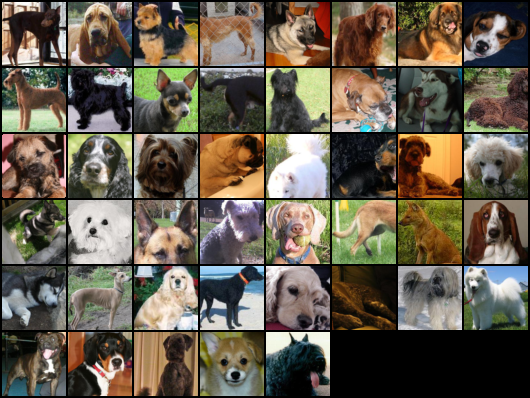

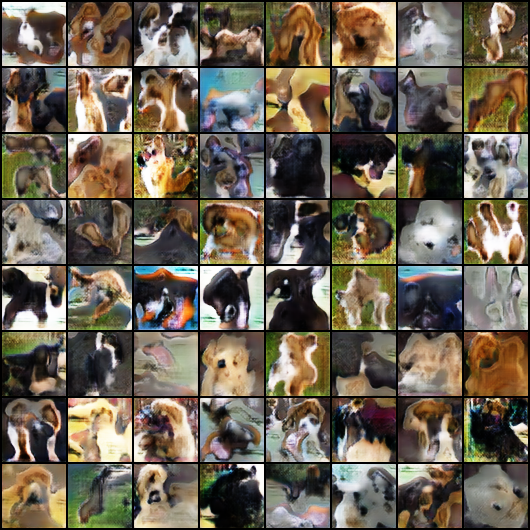

Epoch 10 done. Time per epoch: 2.842[min]


[11/500][141/346] | iteration: 3601 | D_loss: 0.835 | G_loss: 1.77057 | Dx_score: 0.68714 | DG_score1: 0.65141 | DG_score2: 0.60295
Epoch 11 done. Time per epoch: 2.841[min]


Epoch 12 done. Time per epoch: 2.842[min]


[13/500][49/346] | iteration: 4201 | D_loss: 0.83297 | G_loss: 1.7566 | Dx_score: 0.82367 | DG_score1: 0.79487 | DG_score2: 0.75303
Epoch 13 done. Time per epoch: 2.843[min]


[14/500][303/346] | iteration: 4801 | D_loss: 0.78635 | G_loss: 1.84942 | Dx_score: 0.74708 | DG_score1: 0.70517 | DG_score2: 0.66266
Epoch 14 done. Time per epoch: 2.841[min]


Traceback (most recent call last):
Traceback (most recent call last):
  File "/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/work/modules/Ubuntu/14.04/amd64/common/anaconda3/latest/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/work/modul

In [10]:
clear_output_dir()

# ignite objects
trainer = Engine(step)
checkpoint_handler = ModelCheckpoint(args.output_dir, args.CKPT_PREFIX, save_interval=1, n_saved=10, require_empty=False)
timer = Timer(average=True)

# attach running average metrics
monitoring_metrics = ['D_loss', 'G_loss', 'Dx_score', 'DG_score1', 'DG_score2']
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['D_loss']).attach(trainer, 'D_loss')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['G_loss']).attach(trainer, 'G_loss')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['Dx_score']).attach(trainer, 'Dx_score')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['DG_score1']).attach(trainer, 'DG_score1')
RunningAverage(alpha=args.alpha, output_transform=lambda x: x['DG_score2']).attach(trainer, 'DG_score2')

# attach progress bar
pbar = ProgressBar()
pbar.attach(trainer, metric_names=monitoring_metrics)

# adding handlers using `trainer.on` decorator API
@trainer.on(Events.ITERATION_COMPLETED)
def print_logs(engine):
    if (engine.state.iteration - 1) % args.PRINT_FREQ == 0:
        fname = os.path.join(args.output_dir, args.LOGS_FNAME)
        columns = ["iteration", ] + list(engine.state.metrics.keys())
        values = [str(engine.state.iteration), ] + \
                 [str(round(value, 5)) for value in engine.state.metrics.values()]
        with open(fname, 'a') as f:
            if f.tell() == 0:
                print('\t'.join(columns), file=f)
            print('\t'.join(values), file=f)

        message = '[{epoch}/{max_epoch}][{i}/{max_i}]'.format(epoch=engine.state.epoch,
                                                              max_epoch=args.num_epochs,
                                                              i=(engine.state.iteration % len(dataloader)),
                                                              max_i=len(dataloader))
        for name, value in zip(columns, values):
            message += ' | {name}: {value}'.format(name=name, value=value)
        pbar.log_message(message)

@trainer.on(Events.EPOCH_COMPLETED)
def save_fake_example(engine):
    fake = netG(fixed_noise, dog_labels).detach().cpu()
    path = os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(engine.state.epoch))
    vutils.save_image((fake+1.)/2., path, normalize=True)
    
@trainer.on(Events.EPOCH_COMPLETED)
def save_real_example(engine):
    img, _ = engine.state.batch
    path = os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(engine.state.epoch))
    vutils.save_image(img, path, normalize=True)

@trainer.on(Events.EPOCH_COMPLETED)
def display_images(engine):
    if engine.state.epoch % 10 == 0:
        display(Image.open(os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(engine.state.epoch))))
        display(Image.open(os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(engine.state.epoch))))    
    
# adding handlers using `trainer.add_event_handler` method API
trainer.add_event_handler(event_name=Events.EPOCH_COMPLETED, 
                          handler=checkpoint_handler,
                          to_save={
                              'netG': netG,
                              'netD': netD
                          })

# automatically adding handlers via a special `attach` method of `Timer` handler
timer.attach(trainer, 
             start=Events.EPOCH_STARTED, 
             resume=Events.EPOCH_STARTED,
             pause=Events.EPOCH_COMPLETED, 
             step=Events.EPOCH_COMPLETED)

@trainer.on(Events.EPOCH_COMPLETED)
def print_times(engine):
    pbar.log_message(f'Epoch {engine.state.epoch} done. Time per epoch: {timer.value()/60:.3f}[min]')
    timer.reset()
    
@trainer.on(Events.EPOCH_COMPLETED)
def create_plots(engine):
    try:
        import matplotlib as mpl
        mpl.use('agg')

        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt

    except ImportError:
        warnings.warn('Loss plots will not be generated -- pandas or matplotlib not found')

    else:
        df = pd.read_csv(os.path.join(args.output_dir, args.LOGS_FNAME), delimiter='\t', index_col='iteration')
        _ = df.loc[:, list(engine.state.metrics.keys())].plot(subplots=True, figsize=(10, 10))
        _ = plt.xlabel('Iteration number')
        fig = plt.gcf()
        path = os.path.join(args.output_dir, args.PLOT_FNAME)
        fig.savefig(path)
        
@trainer.on(Events.EPOCH_STARTED)
def handle_timeout(engine):
    if time.perf_counter() - kernel_start_time > 31000:
        print("Time limit reached! Stopping kernel!")
        engine.terminate()

        create_plots(engine)
        checkpoint_handler(engine, {
            'netG_exception': netG,
            'netD_exception': netD
        })
        
@trainer.on(Events.EXCEPTION_RAISED)
def handle_exception(engine, e):
    if isinstance(e, KeyboardInterrupt) and (engine.state.iteration > 1):
        engine.terminate()
        warnings.warn('KeyboardInterrupt caught. Exiting gracefully.')

        create_plots(engine)
        checkpoint_handler(engine, {
            'netG_exception': netG,
            'netD_exception': netD
        })

    else:
        raise e
        
trainer.run(dataloader, args.num_epochs)

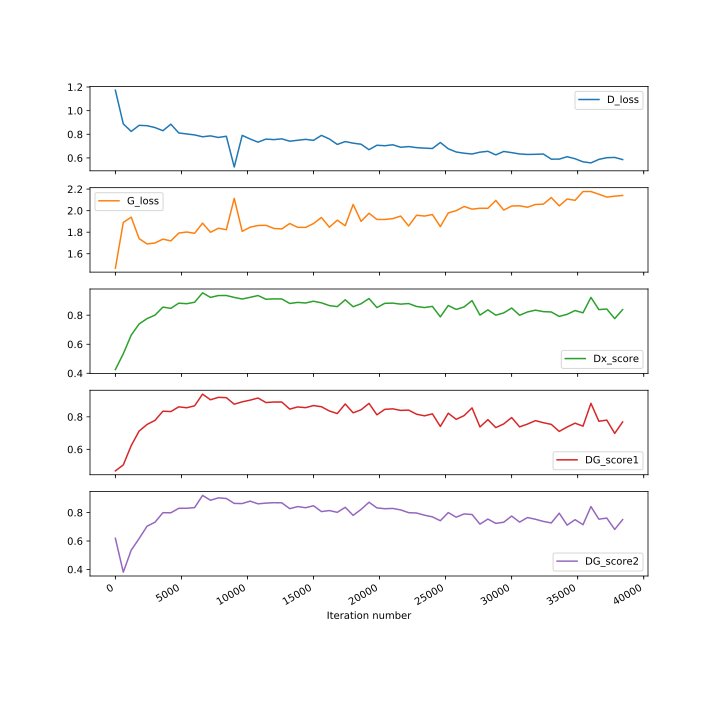

In [11]:
# analysize logs
display(SVG("../output_dir/plot.svg"))

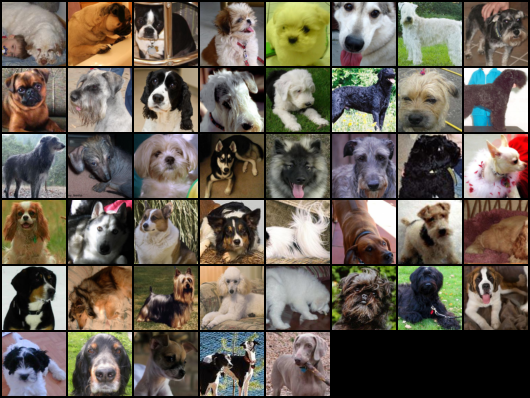

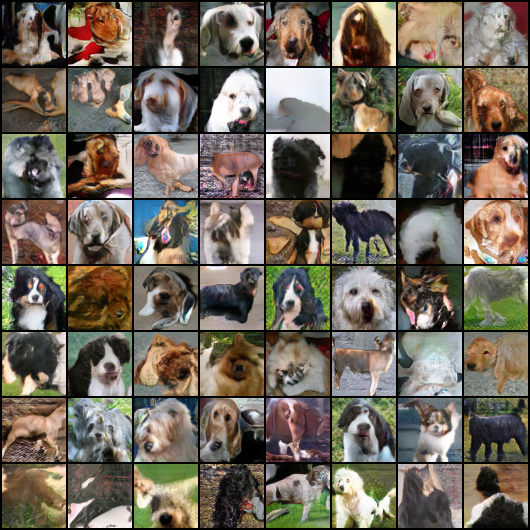

In [12]:
display(Image.open(os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(trainer.state.epoch-1))))
display(Image.open(os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(trainer.state.epoch-1))))

In [13]:
def mse(imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err

def analyse_generated_by_class(n_images=5):
    good_breeds = []
    for l in range(len(decoded_dog_labels)):
        sample = []
        for _ in range(n_images):
            noise = torch.randn(1, args.latent_dim, device=device)
            dog_label = torch.full((1,) , l, device=device, dtype=torch.long)
            gen_image = netG(noise, dog_label).to("cpu").clone().detach().squeeze(0)
            gen_image = gen_image.numpy().transpose(1, 2, 0)
            sample.append(gen_image)
        
        # compare two images generated for the same label, if they're very similar => mode collapse
        d = np.round(np.sum([mse(sample[k], sample[k+1]) for k in range(len(sample)-1)])/n_images, 1)
        if d < 1.0: continue  # had mode colapse(discard)
            
        print(f"Generated breed({d}): ", decoded_dog_labels[l])
        l_noise = torch.randn(n_images, args.latent_dim, device=device)
        l_labels = torch.randint(0, len(encoded_dog_labels), (n_images, ), device=device)
            
        fake = netG(l_noise, l_labels).detach().cpu()
        path = os.path.join(args.output_dir, f'img_{l}.png')
        vutils.save_image((fake+1.)/2., path, normalize=True)
        display(Image.open(os.path.join(args.output_dir, f'img_{l}.png')))    
        
        good_breeds.append(l)
    return good_breeds

In [14]:
from scipy.stats import truncnorm

def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

def create_submit(good_breeds):
    print("Creating submit")
    os.makedirs('../output_images', exist_ok=True)
    im_batch_size = 50
    n_images = 10000
    
    all_dog_labels = np.random.choice(good_breeds, size=n_images, replace=True)
    for i_batch in range(0, n_images, im_batch_size):
#         z = truncated_normal((im_batch_size, args.latent_dim, 1, 1), threshold=1)
#         noise = torch.from_numpy(z).float().to(device)
        noise = torch.randn(im_batch_size, args.latent_dim, device=device)
        dog_labels = torch.from_numpy(all_dog_labels[i_batch: (i_batch+im_batch_size)]).to(device)
        gen_images = netG(noise, dog_labels)
        gen_images = (gen_images.to("cpu").clone().detach() + 1) / 2
        for ii, img in enumerate(gen_images):
            save_image(gen_images[ii, :, :, :], os.path.join('../output_images', f'image_{i_batch + ii:05d}.png'))
            
    import shutil
    shutil.make_archive('images', 'zip', '../output_images')

Generated breed(1.0):  affenpinscher


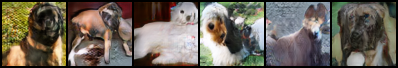

Generated breed(1.0):  afghan_hound


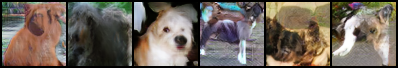

Generated breed(1.0):  african_hunting_dog


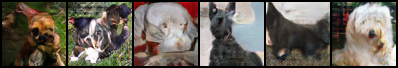

Generated breed(1.0):  airedale


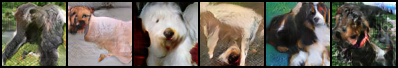

Generated breed(1.2):  american_staffordshire_terrier


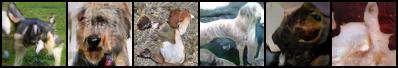

Generated breed(1.2):  appenzeller


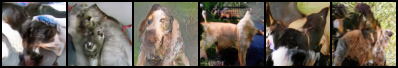

Generated breed(1.1):  australian_terrier


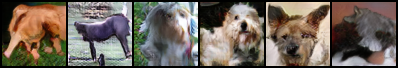

Generated breed(1.1):  basenji


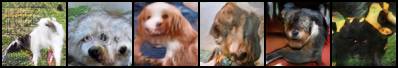

Generated breed(1.2):  basset


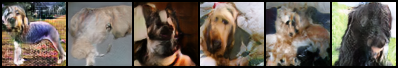

Generated breed(1.0):  beagle


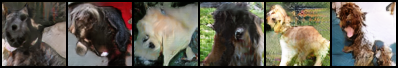

Generated breed(1.0):  bedlington_terrier


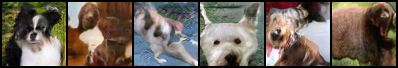

Generated breed(1.0):  bernese_mountain_dog


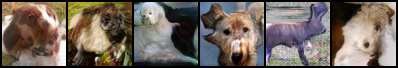

Generated breed(1.1):  black


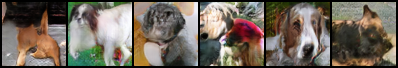

Generated breed(1.0):  blenheim_spaniel


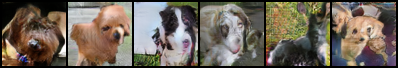

Generated breed(1.1):  bloodhound


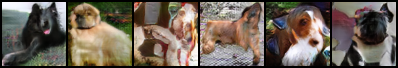

Generated breed(1.0):  bluetick


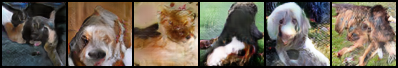

Generated breed(1.0):  border_collie


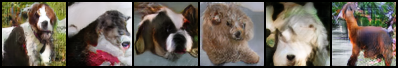

Generated breed(1.2):  borzoi


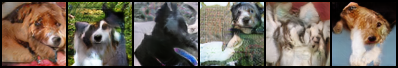

Generated breed(1.2):  boston_bull


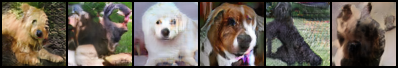

Generated breed(1.1):  bouvier_des_flandres


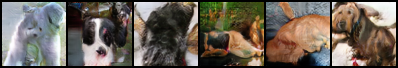

Generated breed(1.1):  boxer


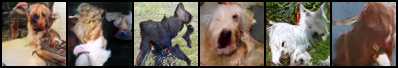

Generated breed(1.0):  brabancon_griffon


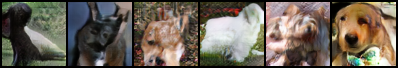

Generated breed(1.1):  briard


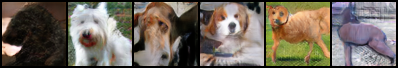

Generated breed(1.2):  brittany_spaniel


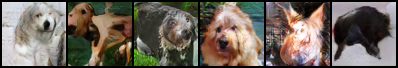

Generated breed(1.0):  bull_mastiff


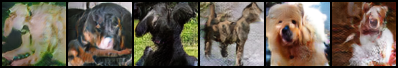

Generated breed(1.1):  cairn


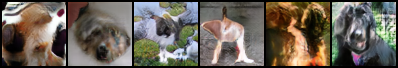

Generated breed(1.0):  cardigan


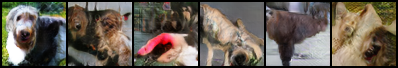

Generated breed(1.0):  chesapeake_bay_retriever


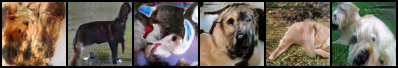

Generated breed(1.1):  chihuahua


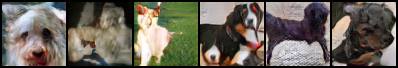

Generated breed(1.2):  clumber


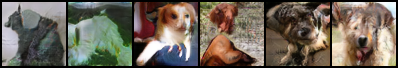

Generated breed(1.1):  cocker_spaniel


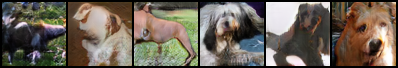

Generated breed(1.3):  collie


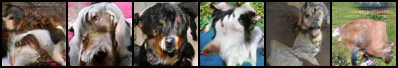

Generated breed(1.1):  curly


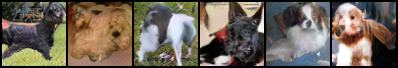

Generated breed(1.0):  dandie_dinmont


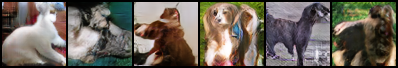

Generated breed(1.0):  dingo


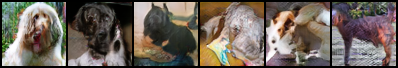

Generated breed(1.3):  doberman


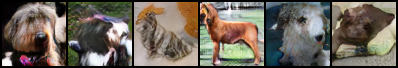

Generated breed(1.2):  english_foxhound


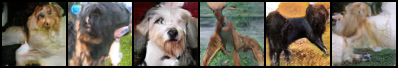

Generated breed(1.0):  english_setter


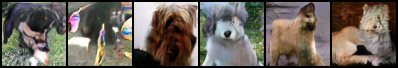

Generated breed(1.1):  english_springer


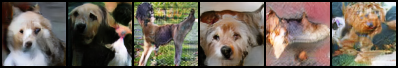

Generated breed(1.1):  entlebucher


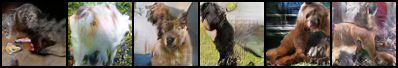

Generated breed(1.0):  eskimo_dog


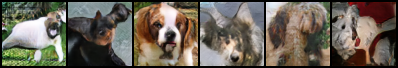

Generated breed(1.0):  flat


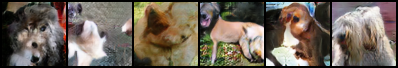

Generated breed(1.1):  french_bulldog


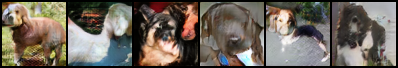

Generated breed(1.1):  german_shepherd


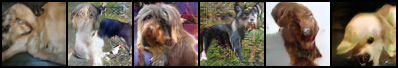

Generated breed(1.0):  german_short


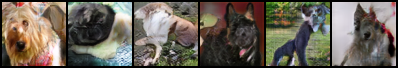

Generated breed(1.1):  giant_schnauzer


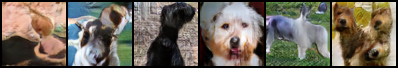

Generated breed(1.0):  great_pyrenees


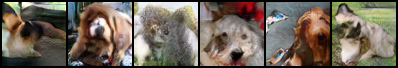

Generated breed(1.1):  ibizan_hound


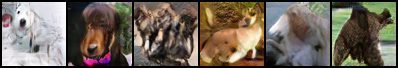

Generated breed(1.0):  irish_setter


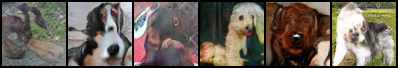

Generated breed(1.0):  irish_water_spaniel


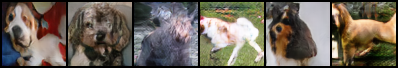

Generated breed(1.0):  italian_greyhound


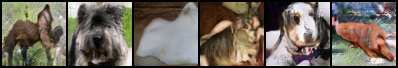

Generated breed(1.2):  japanese_spaniel


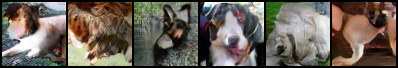

Generated breed(1.0):  keeshond


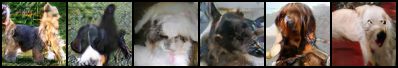

Generated breed(1.1):  kelpie


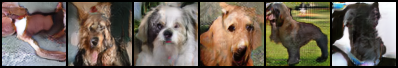

Generated breed(1.0):  komondor


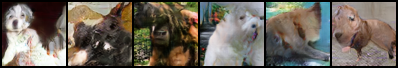

Generated breed(1.2):  kuvasz


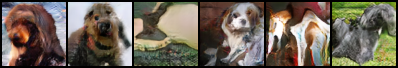

Generated breed(1.1):  labrador_retriever


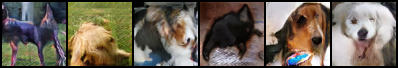

Generated breed(1.1):  lakeland_terrier


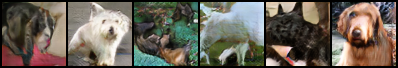

Generated breed(1.2):  lhasa


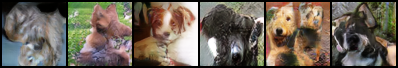

Generated breed(1.0):  malamute


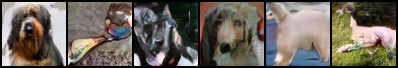

Generated breed(1.1):  maltese_dog


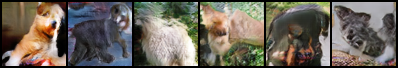

Generated breed(1.1):  mexican_hairless


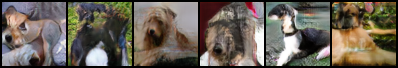

Generated breed(1.1):  miniature_pinscher


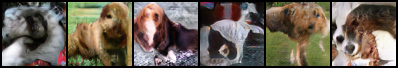

Generated breed(1.0):  miniature_poodle


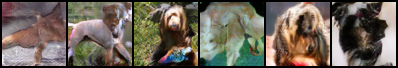

Generated breed(1.2):  miniature_schnauzer


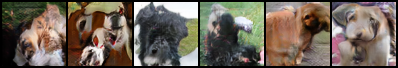

Generated breed(1.1):  newfoundland


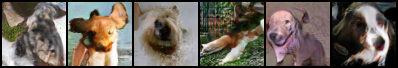

Generated breed(1.0):  norwegian_elkhound


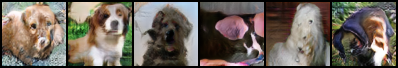

Generated breed(1.1):  old_english_sheepdog


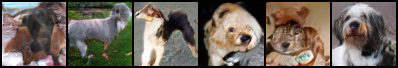

Generated breed(1.2):  otterhound


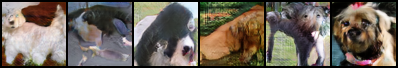

Generated breed(1.1):  papillon


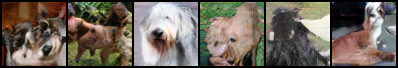

Generated breed(1.0):  pekinese


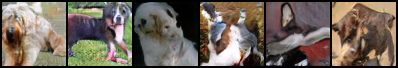

Generated breed(1.1):  pembroke


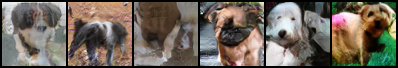

Generated breed(1.1):  pomeranian


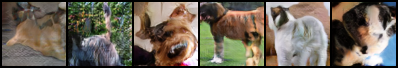

Generated breed(1.1):  pug


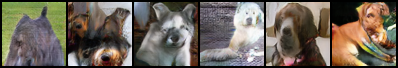

Generated breed(1.0):  redbone


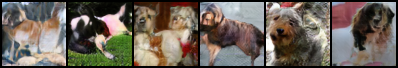

Generated breed(1.0):  rhodesian_ridgeback


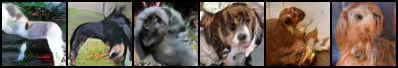

Generated breed(1.1):  rottweiler


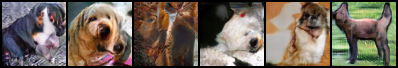

Generated breed(1.2):  saint_bernard


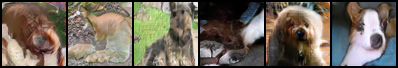

Generated breed(1.0):  saluki


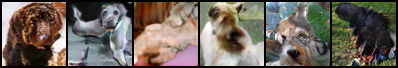

Generated breed(1.0):  samoyed


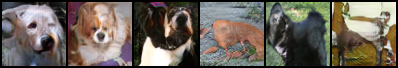

Generated breed(1.1):  schipperke


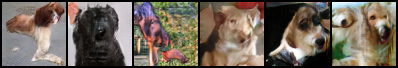

Generated breed(1.0):  scottish_deerhound


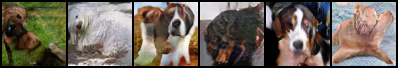

Generated breed(1.2):  sealyham_terrier


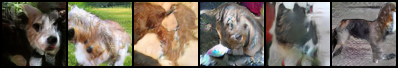

Generated breed(1.1):  shetland_sheepdog


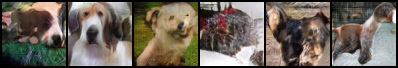

Generated breed(1.2):  shih


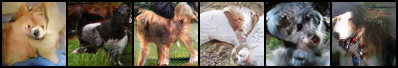

Generated breed(1.2):  staffordshire_bullterrier


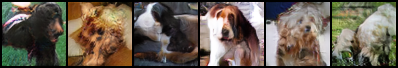

Generated breed(1.4):  standard_poodle


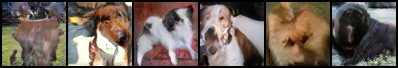

Generated breed(1.0):  standard_schnauzer


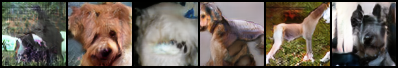

Generated breed(1.1):  sussex_spaniel


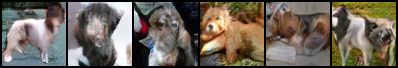

Generated breed(1.0):  tibetan_mastiff


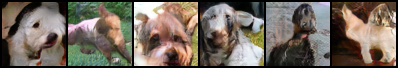

Generated breed(1.1):  tibetan_terrier


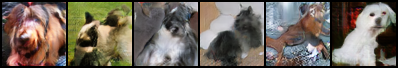

Generated breed(1.0):  toy_poodle


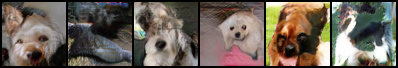

Generated breed(1.1):  toy_terrier


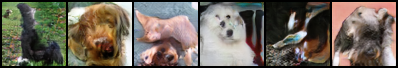

Generated breed(1.1):  vizsla


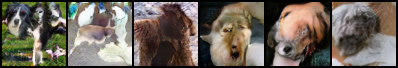

Generated breed(1.2):  walker_hound


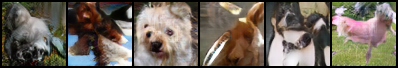

Generated breed(1.0):  weimaraner


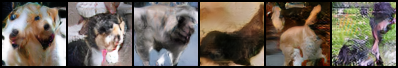

Generated breed(1.0):  welsh_springer_spaniel


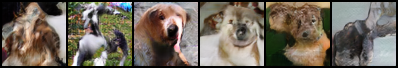

Generated breed(1.0):  west_highland_white_terrier


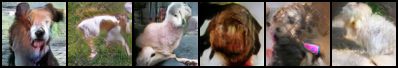

Generated breed(1.1):  whippet


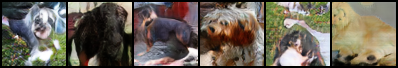

Generated breed(1.2):  wire


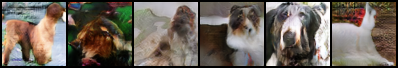

Generated breed(1.2):  yorkshire_terrier


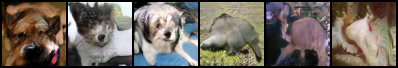

Creating submit


In [15]:
good_breeds = analyse_generated_by_class(6)
create_submit(good_breeds)

In [16]:


# if not os.path.exists('../output_images'):
#     os.mkdir('../output_images')
# im_batch_size = 50
# n_images=10000
# for i_batch in range(0, n_images, im_batch_size):
# #     z = truncated_normal((im_batch_size, args.latent_dim, 1, 1), threshold=1)
# #     gen_z = torch.from_numpy(z).float().to(device)
#     gen_z = torch.randn(im_batch_size, args.latent_dim, 1, 1, device=device)
#     gen_images = (netG(gen_z)+1.)/2. # denormalize
#     images = gen_images.to("cpu").clone().detach()
#     images = images.numpy().transpose(0, 2, 3, 1)
#     for i_image in range(gen_images.size(0)):
#         save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


# import shutil
# shutil.make_archive('images', 'zip', '../output_images')

In [17]:
#####################
### Eval Code
#####################

import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
# from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """

    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2

In [18]:
if COMPUTE_LB:
    # UNCOMPRESS OUR IMGAES
    shutil.unpack_archive('images.zip', extract_dir='../tmp/images2')

    # COMPUTE LB SCORE
    m2 = []; s2 =[]; f2 = []
    user_images_unzipped_path = '../tmp/images2/'
    images_path = [user_images_unzipped_path,'../input/generative-dog-images/all-dogs/all-dogs/']
    public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

    fid_epsilon = 10e-15

    fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
    distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
    print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))
    
    # REMOVE FILES TO PREVENT KERNEL ERROR OF TOO MANY FILES
    ! rm -r ../tmp

In [19]:
print(f"Done in {(time.time() - starttime)/60:.4f} minutes.")

Done in 520.7650 minutes.
